In [246]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

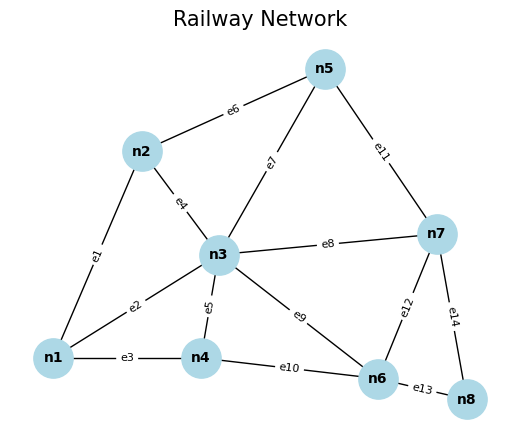

In [247]:
# 1. 그래프 정의
nodes = {
    "n1": (0, 0), "n2": (1.5, 5), "n3": (2.8, 2.5), "n4": (2.5, 0),
    "n5": (4.6, 7), "n6": (5.5, -0.5), "n7": (6.5, 3), "n8": (7, -1)
}

edges = {
    "e1": ("n1", "n2"), "e2": ("n1", "n3"), "e3": ("n1", "n4"),
    "e4": ("n2", "n3"), "e5": ("n3", "n4"), "e6": ("n5", "n2"),
    "e7": ("n5", "n3"), "e8": ("n3", "n7"), "e9": ("n3", "n6"), 
    "e10": ("n6", "n4"), "e11": ("n5", "n7"), "e12": ("n7", "n6"), 
    "e13": ("n6", "n8"), "e14": ("n7", "n8")
}

G = nx.Graph() 
for node, position in nodes.items():
    G.add_node(node, pos=position)
for edge_id, (u, v) in edges.items():
    pos_u, pos_v = nodes[u], nodes[v]
    distance = math.sqrt((pos_u[0] - pos_v[0])**2 + (pos_u[1] - pos_v[1])**2)
    G.add_edge(u, v, label=edge_id, flow=0, capacity=2, weight=distance)  # 노드와 노드 사이 거리를 가중치로 설정하여 최단경로탐색 시 더 짧은 거리를 우선순위로 함
        
plt.figure(figsize=(5, 4))
pos = nx.get_node_attributes(G, 'pos')
edge_labels = nx.get_edge_attributes(G, 'label') 
nx.draw(G, pos, with_labels=True, node_size=800, node_color="lightblue", font_size=10, font_weight="bold")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)
plt.title("Railway Network", fontsize=15)
plt.show()


### **Random OD pair 생성**
각 OD pair에 대한 shortest path 계산 및 초기 failed edge(flow>capacity) 탐색

In [249]:
# 2. OD pair 생성
OD_pairs = []
node_list = list(G.nodes)

while len(OD_pairs) < 5:  # OD 쌍 개수 설정
                           # Issue 1 : 수요에 대한 값을 어떻게 정할 것인가?
    s = random.choice(node_list)  
    t = random.choice(node_list) 
    if s != t:  
        OD_pairs.append((s, t))

# 2.1. 초기 OD pair 최단 경로 계산
print("\nProcessing OD Pairs and Updating Flow:")
for idx, (s, t) in enumerate(OD_pairs, start=1):
    if nx.has_path(G, s, t): 
        path = nx.shortest_path(G, source=s, target=t, weight='weight')
        print(f"OD Pair {idx}: {s} -> {t}, Shortest Path: {path}")

        # 경로에 따라 flow 업데이트
        for i in range(len(path) - 1):
            u, v = path[i], path[i + 1]
            G[u][v]['flow'] += 1  # 각 edge에 1 unit의 flow 추가
    else:
        print(f"OD Pair {idx}: {s} -> {t}, No path exists.")

# 전체 엣지 상태 출력
print("\nEdge States After Processing All OD Pairs:")
failed_edges = set()  # capacity < flow인 엣지를 failed_edges로 분류
for u, v, data in G.edges(data=True):
    if data['flow'] > data['capacity']:
        print(f"Edge ({u}, {v}): Flow={data['flow']}, Capacity={data['capacity']} - exceeded capacity!")
        failed_edges.add(data['label']) 
    else:
        print(f"Edge ({u}, {v}): Flow={data['flow']}, Capacity={data['capacity']}")

failed_edges_list = list(failed_edges)
print("\nFailed Edges:", failed_edges_list)


Processing OD Pairs and Updating Flow:
OD Pair 1: n4 -> n1, Shortest Path: ['n4', 'n1']
OD Pair 2: n5 -> n7, Shortest Path: ['n5', 'n7']
OD Pair 3: n4 -> n5, Shortest Path: ['n4', 'n3', 'n5']
OD Pair 4: n3 -> n4, Shortest Path: ['n3', 'n4']
OD Pair 5: n5 -> n2, Shortest Path: ['n5', 'n2']

Edge States After Processing All OD Pairs:
Edge (n1, n2): Flow=0, Capacity=2
Edge (n1, n3): Flow=0, Capacity=2
Edge (n1, n4): Flow=1, Capacity=2
Edge (n2, n3): Flow=0, Capacity=2
Edge (n2, n5): Flow=1, Capacity=2
Edge (n3, n4): Flow=2, Capacity=2
Edge (n3, n5): Flow=1, Capacity=2
Edge (n3, n7): Flow=0, Capacity=2
Edge (n3, n6): Flow=0, Capacity=2
Edge (n4, n6): Flow=0, Capacity=2
Edge (n5, n7): Flow=1, Capacity=2
Edge (n6, n7): Flow=0, Capacity=2
Edge (n6, n8): Flow=0, Capacity=2
Edge (n7, n8): Flow=0, Capacity=2

Failed Edges: []


### **초기 failed edge와 simulation case에 따른 failure edge 제거**

In [250]:
# 3. 초기 파괴된 엣지 및 추가적으로 파괴된 엣지 제거
def fail_edges(G, additional_failed_edges, existing_failed_edges):
    failed_edges = list(existing_failed_edges)  # 기존 실패한 엣지 포함
    for edge_id in additional_failed_edges:
        failed_edge = None

        # 엣지 ID로 해당 엣지 찾기
        for u, v, data in G.edges(data=True):
            if data['label'] == edge_id:
                failed_edge = (u, v)
                break

        # 엣지 제거
        if failed_edge and G.has_edge(*failed_edge):
            G.remove_edge(*failed_edge)
            failed_edges.append(failed_edge)
            print(f"Edge {edge_id} ({failed_edge}) removed (failure).")
        else:
            print(f"Edge {edge_id} not found or already removed.")
    return failed_edges

# 기존 실패한 엣지 ID 가져오기
existing_failed_edges = failed_edges_list 

# 새로운 실패 엣지 ID 선택
all_edge_ids = [data['label'] for _, _, data in G.edges(data=True)]
available_edge_ids = [edge_id for edge_id in all_edge_ids if edge_id not in existing_failed_edges]

n = 3  # Number of additional failed edges
       # Simulation case에 따라 실패 엣지 개수 설정
random_failed_edge_ids = random.sample(available_edge_ids, n)

# 기존 실패 엣지와 새로운 실패 엣지 병합
print(f"\nExisting Failed Edges: {existing_failed_edges}")
print(f"Newly Selected Edges to Fail: {random_failed_edge_ids}")

all_failed_edge_ids = existing_failed_edges + random_failed_edge_ids
print(f"\nAll Failed Edges: {all_failed_edge_ids}")
final_failed_edges = fail_edges(G, all_failed_edge_ids, existing_failed_edges)



Existing Failed Edges: []
Newly Selected Edges to Fail: ['e4', 'e11', 'e13']

All Failed Edges: ['e4', 'e11', 'e13']
Edge e4 (('n2', 'n3')) removed (failure).
Edge e11 (('n5', 'n7')) removed (failure).
Edge e13 (('n6', 'n8')) removed (failure).


### **Load Redistribution**

In [251]:
# 4. OD 쌍별 flow 재분배
# Reset flow before processing each OD pair
for u, v, data in G.edges(data=True):
    data['flow'] = 0  # 모든 엣지의 flow를 초기화

print("\nProcessing OD Pairs and Updating Flow:")
for s, t in OD_pairs:
    if nx.has_path(G, s, t):
        path = nx.shortest_path(G, source=s, target=t, weight='weight')
        print(f"OD Pair ({s}, {t}): Shortest Path -> {path}")

        # Flow 재분배 및 용량 확인
        for i in range(len(path) - 1):
            u, v = path[i], path[i + 1]
            G[u][v]['flow'] += 1  # 각 edge에 1 unit의 flow 추가
            if G[u][v]['flow'] > G[u][v]['capacity']:
                print(f"Edge ({u}, {v}) exceeded capacity! Disconnecting...")
                G.remove_edge(u, v)
    else:
        print(f"OD Pair ({s}, {t}) is NOT connected.")

# 전체 엣지 상태 출력
print("\nEdge States After Processing All OD Pairs:")
for u, v, data in G.edges(data=True):
    print(f"Edge ({u}, {v}): Flow={data['flow']}, Capacity={data['capacity']}")
 


Processing OD Pairs and Updating Flow:
OD Pair (n4, n1): Shortest Path -> ['n4', 'n1']
OD Pair (n5, n7): Shortest Path -> ['n5', 'n3', 'n7']
OD Pair (n4, n5): Shortest Path -> ['n4', 'n3', 'n5']
OD Pair (n3, n4): Shortest Path -> ['n3', 'n4']
OD Pair (n5, n2): Shortest Path -> ['n5', 'n2']

Edge States After Processing All OD Pairs:
Edge (n1, n2): Flow=0, Capacity=2
Edge (n1, n3): Flow=0, Capacity=2
Edge (n1, n4): Flow=1, Capacity=2
Edge (n2, n5): Flow=1, Capacity=2
Edge (n3, n4): Flow=2, Capacity=2
Edge (n3, n5): Flow=2, Capacity=2
Edge (n3, n7): Flow=1, Capacity=2
Edge (n3, n6): Flow=0, Capacity=2
Edge (n4, n6): Flow=0, Capacity=2
Edge (n6, n7): Flow=0, Capacity=2
Edge (n7, n8): Flow=0, Capacity=2
